## Heart attack prediction with k-Nearest Neighbors

In this notebook, my goal is to maximize the performance of the kNN predictive algorithm. I will achieve this by conducting a comprehensive analysis, using different evaluation metrics, and fine-tuning hyperparameters. Additionally, I will implement PCA analysis, pipelines, and various cross-validation methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

### Heart Attack Analysis & Prediction Dataset

source: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
#### Columns:
<ul>
  <li>
    Age: Age of the patient
  </li>
  <li>
    Sex: Sex of the patient
  </li>
  <li>
    exang: Exercise induced angina (1 = yes; 0 = no)
  </li>
  <li>
    ca: Number of major vessels (0-3)
  </li>
  <li>
    cp: Chest Pain type
    <ul>
      <li>Value 1: Typical angina</li>
      <li>Value 2: Atypical angina</li>
      <li>Value 3: Non-anginal pain</li>
      <li>Value 4: Asymptomatic</li>
    </ul>
  </li>
  <li>
    trtbps: Resting blood pressure (in mm Hg)
  </li>
  <li>
    chol: Cholesterol in mg/dl fetched via BMI sensor
  </li>
  <li>
    fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
  </li>
  <li>
    rest_ecg: Resting electrocardiographic results
    <ul>
      <li>Value 0: Normal</li>
      <li>Value 1: ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)</li>
      <li>Value 2: Showing probable or definite left ventricular hypertrophy by Estes' criteria</li>
    </ul>
  </li>
  <li>
    thalach: Maximum heart rate achieved
  </li>
  <li>
    target: 0 = Less chance of heart attack, 1 = More chance of heart attack
  </li>
</ul>


In [2]:
# loading the dataset
df = pd.read_csv("datasets/heart.csv")
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Exploring the dataset

General information about the dataset, not related to predictive analysis yet

In [3]:
# checking for missing values
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

There are no missing values

In [4]:
# checking datatypes
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

All features and target are numerical

In [5]:
# summary statistics
df.describe().round()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0
mean,54.0,1.0,1.0,132.0,246.0,0.0,1.0,150.0,0.0,1.0,1.0,1.0,2.0,1.0
std,9.0,0.0,1.0,18.0,52.0,0.0,1.0,23.0,0.0,1.0,1.0,1.0,1.0,0.0
min,29.0,0.0,0.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,48.0,0.0,0.0,120.0,211.0,0.0,0.0,134.0,0.0,0.0,1.0,0.0,2.0,0.0
50%,55.0,1.0,1.0,130.0,240.0,0.0,1.0,153.0,0.0,1.0,1.0,0.0,2.0,1.0
75%,61.0,1.0,2.0,140.0,274.0,0.0,1.0,166.0,1.0,2.0,2.0,1.0,3.0,1.0
max,77.0,1.0,3.0,200.0,564.0,1.0,2.0,202.0,1.0,6.0,2.0,4.0,3.0,1.0


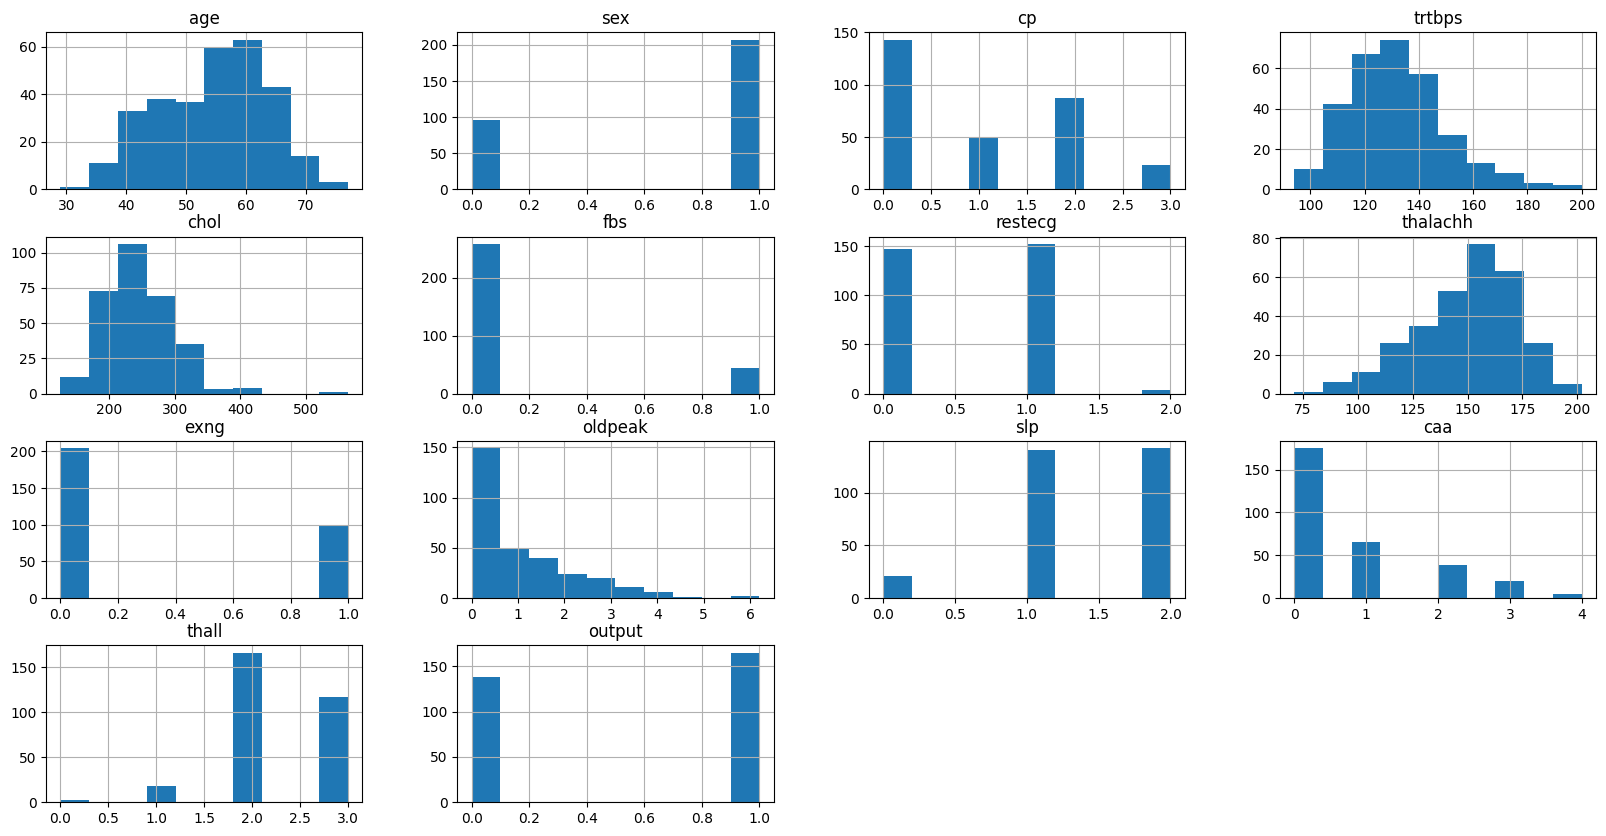

In [6]:
# plotting the distribution among features
df.hist(figsize=(20,10))
plt.show()

The dataset seems free of outliers

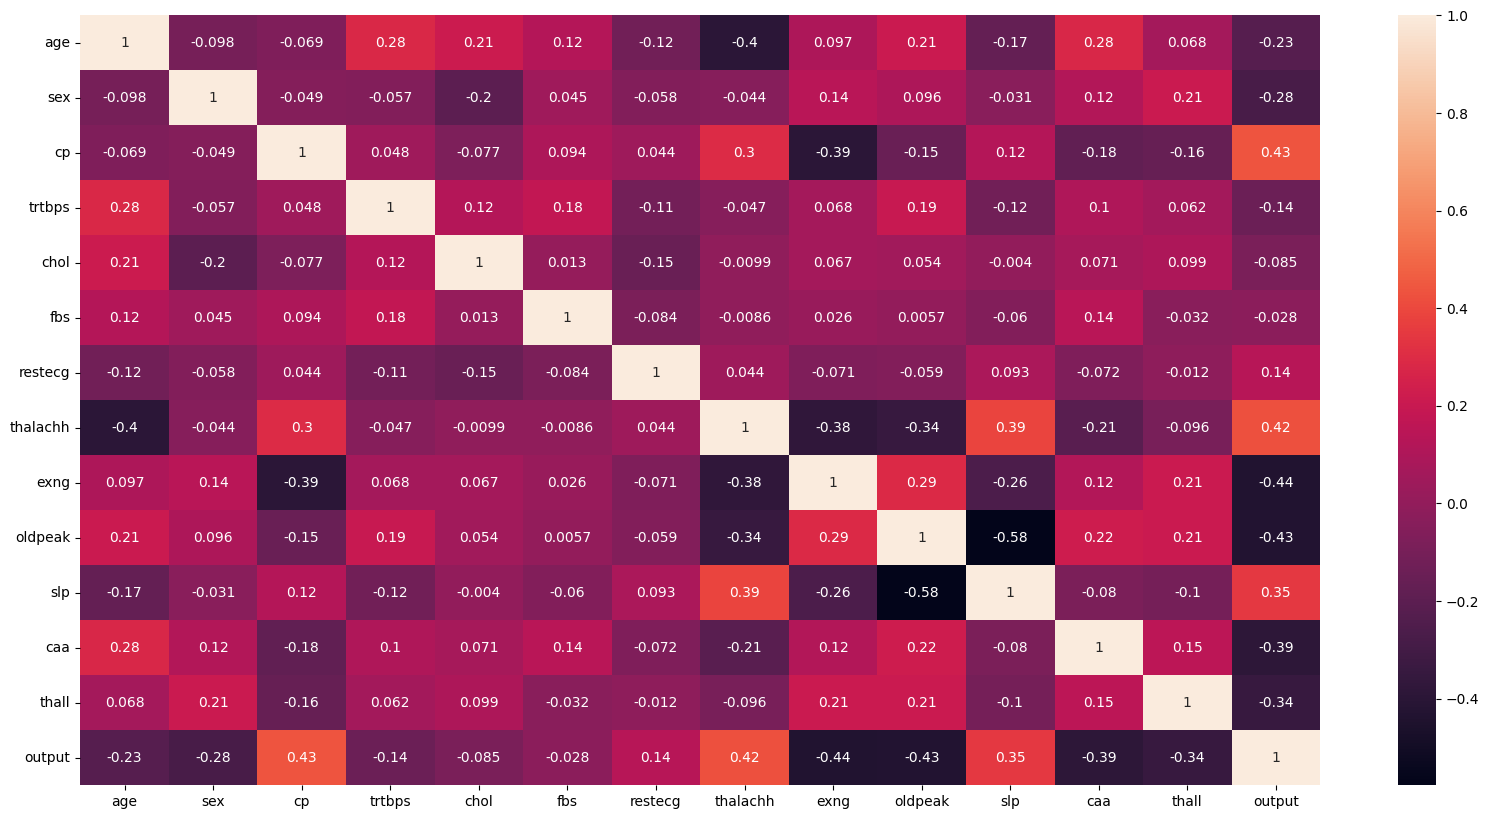

In [7]:
# correlation between features
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

No strong linear correlations between features and between features and target were observed

## Analyzing Feature-Target Relationships

In [8]:
# determine which features are numerical continuous and numerical categorical, by checking amount of unique values by column
df.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

Based on distribution and amount of unique values by feature it can be said that categorical features are: sex, cp, fbs, restecg, exng, slp, caa, thall and output (target variable)


In [9]:
# extract continuous features for analysis
continuous_features = ["age","trtbps","chol","thalachh","oldpeak"]
df_con = df[continuous_features].copy()
df_con

,age,trtbps,chol,thalachh,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6
...,...,...,...,...,...
298,57,140,241,123,0.2
299,45,110,264,132,1.2
300,68,144,193,141,3.4
301,57,130,131,115,1.2


In [10]:
# extract categorical features for analysis
df_cat = df[df.drop(columns=continuous_features).columns].copy()
df_cat

,sex,cp,fbs,restecg,exng,slp,caa,thall,output
0,1,3,1,0,0,0,0,1,1
1,1,2,0,1,0,0,0,2,1
2,0,1,0,0,0,2,0,2,1
3,1,1,0,1,0,2,0,2,1
4,0,0,0,1,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...
298,0,0,0,1,1,1,0,3,0
299,1,3,0,1,0,1,0,3,0
300,1,0,1,1,0,1,2,3,0
301,1,0,0,1,1,1,1,3,0


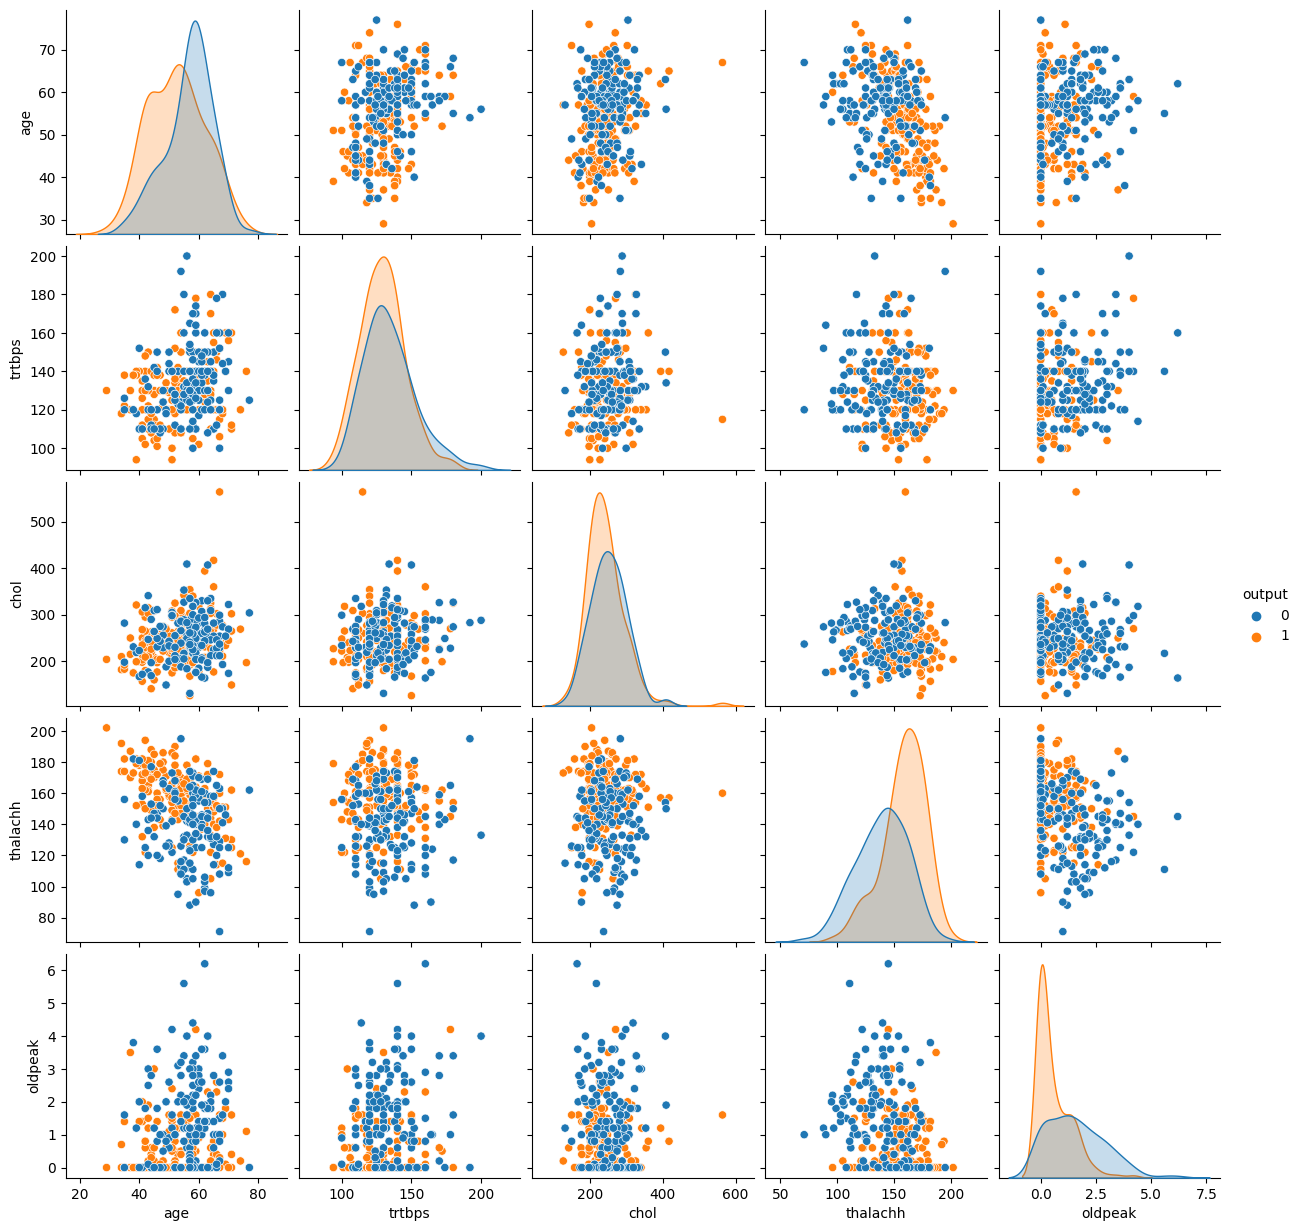

In [11]:
# visually analysing if there are relationships between features which distinguish output
sns.pairplot(data=df[df_con.columns.to_list()+["output"]],hue="output")

On the scatter plot features seem to show different distribution/grouping based on target variable, so the hypothesis is that "There is a difference in distributon of the data between output classes". To reject the hypothesis or not ANOVA test will be used

In [12]:
# ANOVA for the continuous features and the target
f_score, p_value = f_classif(df_con,df["output"])

for i,test in enumerate(df_con.columns):
    print(f"{test}: F-value = {f_score[i]}, p-value {p_value[i]}")
    print()

age: F-value = 16.11669982318991, p-value 7.524801303436338e-05

trtbps: F-value = 6.458168674003441, p-value 0.011546059200245202

chol: F-value = 2.2029834463816798, p-value 0.13879032695589258

thalachh: F-value = 65.12010440124943, p-value 1.6973376386571855e-14

oldpeak: F-value = 68.55143941030717, p-value 4.085346391354515e-15



Based on the scatter plot and ANOVA analysis, 'chol' and "trtbps" features will be rejected. The F-values are small, and the p-value exceeds the 5% boundary for 'chol'. Furthermore, the scatter plot, when grouped by the output value, shows that the points are mixing, and no distinguished groups can be seen

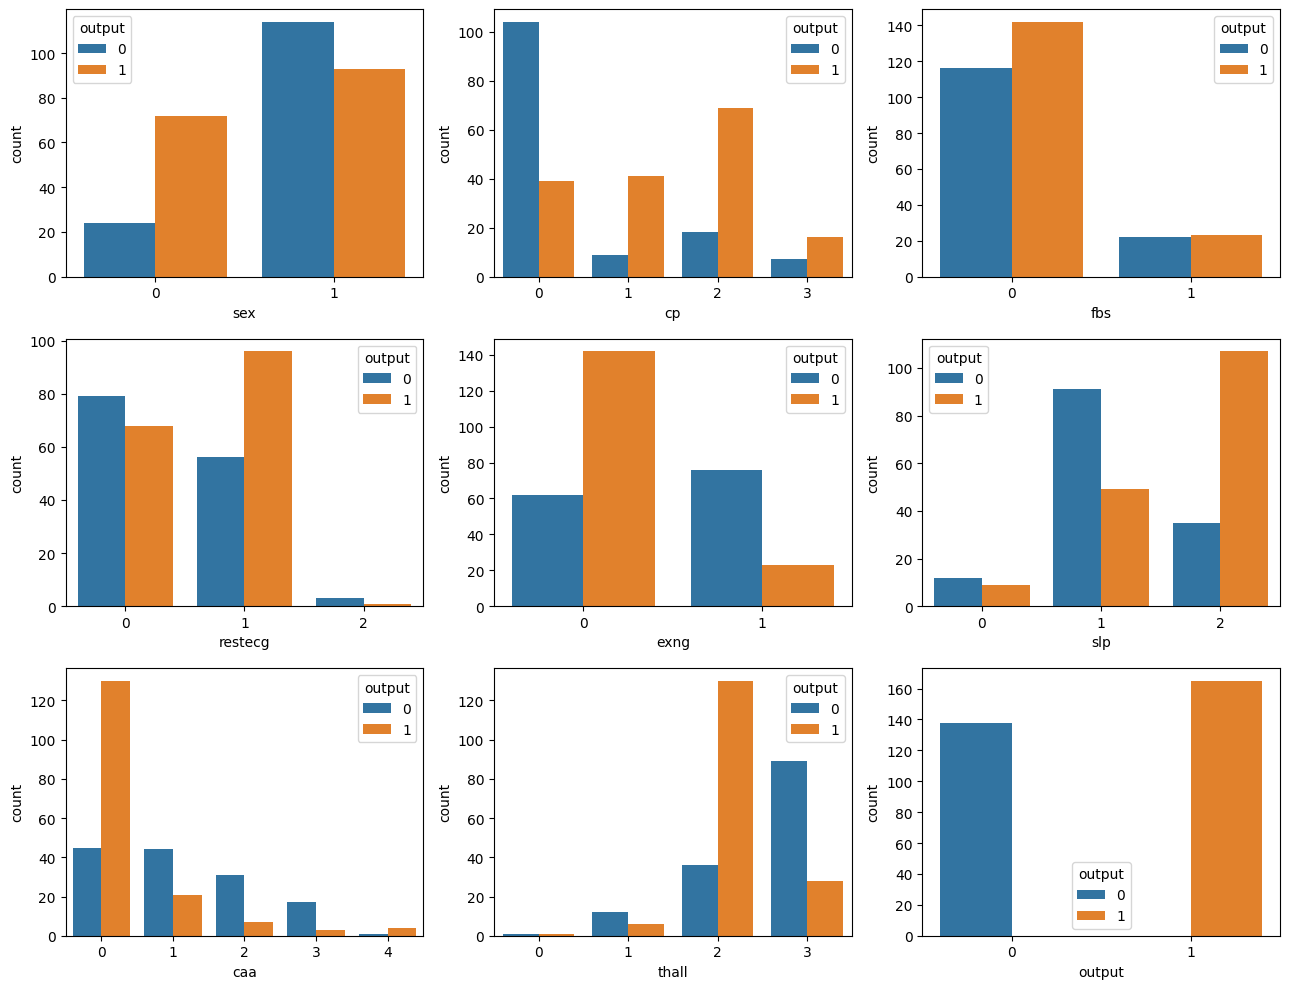

In [13]:
# checking if classes of categorical features determine output
fig,ax = plt.subplots(3,3,figsize=(13,10))

x = 0
y = 0

for column in df_cat.columns:
    sns.countplot(x=df[column], hue=df["output"],ax=ax[x,y])
    y+=1
    if y > 2:
        x+=1
        y=0
        
plt.tight_layout()        

Clearly some categorical features show impact on the output. The significance of the pattern will be analyzed using chi-squared test, also type of categorical data needs to be define due to encoding difference between nominal and ordinal data

In [14]:
# Chi-squared will determine if there is significant difference in output distribution between classes of features
chi_squared, p_value = chi2(df_cat,df["output"])

for i,test in enumerate(df_cat.columns):
    print(f"{test}: Chi2-value = {chi_squared[i]}, p-value {p_value[i]}")
    print()

sex: Chi2-value = 7.576834507647363, p-value 0.005912317631482072

cp: Chi2-value = 62.59809791039943, p-value 2.5349817930518245e-15

fbs: Chi2-value = 0.20293368467281492, p-value 0.6523632084561484

restecg: Chi2-value = 2.978270750988143, p-value 0.08438939039037469

exng: Chi2-value = 38.91437697129396, p-value 4.42807388312911e-10

slp: Chi2-value = 9.804095197255574, p-value 0.001741236847382655

caa: Chi2-value = 66.4407651172357, p-value 3.605676625752096e-16

thall: Chi2-value = 5.7918529711930535, p-value 0.016100609835321415

output: Chi2-value = 138.0, p-value 7.287679729162903e-32



The features "fbs" and "restecg" do not have a significant impact on the output, as indicated by the barplot. Additionally, the chi-squared test revealed a low value and a high p-value, further supporting the lack of significance in these features.

By looking at data description and output distribution based on feature classes it can be observed that:
- Binary features: sex, exng
- Nominal features: cp, slp, caa, thall
- Ordinal features: none

1    54.46
0    45.54
Name: output, dtype: float64


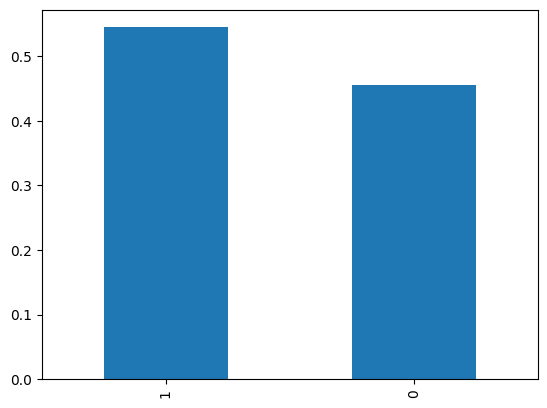

In [15]:
# distribution of output itself
df["output"].value_counts(normalize=True).plot(kind="bar")
print((df["output"].value_counts(normalize=True)*100).round(2))

54% of output values are "1" and the rest 46% are "0"

### Exploratory data analysis conclusions

1. The dataset is complete with no missing values.
2. The dataset contains a few minor outliers.
3. There is no evidence of multicollinearity among the features.
4. The analysis revealed that the continuous features "chol" and "trtbps" are not informative or useful.
5. The categorical features "fbs" and "restecg" were found to have no significant impact on the analysis.
6. Among categorical features "cp", "slp", "caa", "thall" require One-hot Encoding.
7. Target distribution is pretty balanced.
8. Null accuracy is 54%

In [16]:
# removing redundant features
data = df.drop(columns=["chol","trtbps","fbs","restecg"])

### PCA analysis for continuous features

This analysis will show wether all these features together show some usefull clusters and grouping tendency

In [17]:
"""The continuous features will be transformed for PCA analysis purposes. However, these transformed data points cannot 
be used during model building, as doing so would cause data leakage from the testing set. This is just for PCA."""

# getting all continuous columns minus continuous columns there were rejected
pca_data = df[list(set(df_con.columns.to_list()).intersection(data.columns.to_list()))]
pca_data.head()

,oldpeak,age,thalachh
0,2.3,63,150
1,3.5,37,187
2,1.4,41,172
3,0.8,56,178
4,0.6,57,163


In [18]:
# scaling these features
pca_data = StandardScaler().fit_transform(pca_data)
pca_data[:3,:]

array([[ 1.08733806,  0.9521966 ,  0.01544279],
       [ 2.12257273, -1.91531289,  1.63347147],
       [ 0.31091206, -1.47415758,  0.97751389]])

In [19]:
# fitting the PCA and transforming given data
pca = PCA()
pca.fit(pca_data)
pca_data = pd.DataFrame(pca.transform(pca_data))
pca_data.head()

,0,1,2
0,-1.101551,0.248038,-0.902377
1,1.004745,2.981364,-0.971557
2,1.291652,1.245816,-0.070131
3,0.793204,-0.169306,-0.977086
4,0.405367,-0.427004,-0.471726


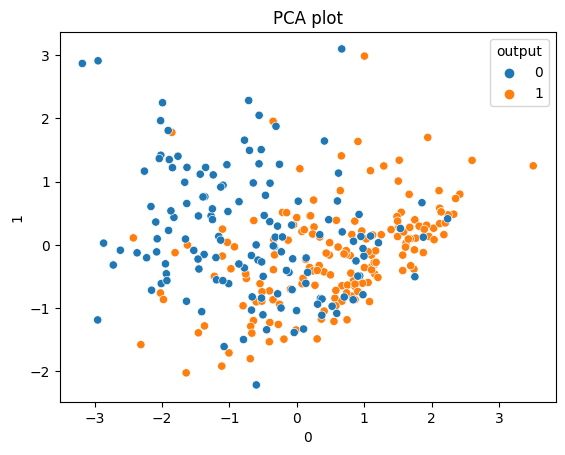

In [20]:
# plotting the PCA plot
sns.scatterplot(x=pca_data.iloc[:,0],y=pca_data.iloc[:,1],hue=data["output"])
plt.title("PCA plot")
plt.show()

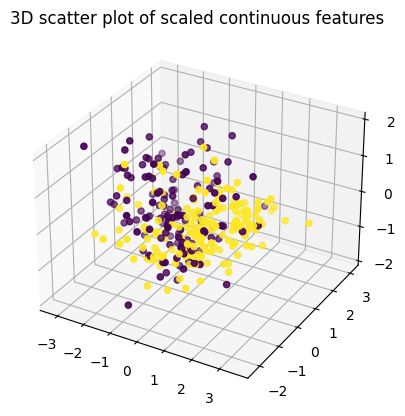

In [21]:
# 3D scatter plot on scaled data
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(pca_data[0],pca_data[1],pca_data[2], c = data["output"])
plt.title("3D scatter plot of scaled continuous features")

plt.show()

Distnict groups can be seen on both plots, which suggests that continuous features have predictive value

## Developing kNN model

Data will be split into training, validation and testing. Testing set will be used on the very end after best model is selected and will serve as new unseen data



### Preparing data splits

In [22]:
# taking random 25 samples from the main dataset
testing_data = data.sample(n=25,random_state=1)
# dropping used samples
data.drop(index=testing_data.index,inplace=True)

testing_data.head()

,age,sex,cp,thalachh,exng,oldpeak,slp,caa,thall,output
204,62,0,0,145,0,6.2,0,3,3,0
159,56,1,1,163,0,0.0,2,0,3,1
219,48,1,0,150,1,0.0,2,2,3,0
174,60,1,0,132,1,2.4,1,2,3,0
184,50,1,0,128,0,2.6,1,0,3,0


In [23]:
data.shape

(278, 10)

There are 25 rows less

In [24]:
# extracting output from features
X = data.drop(columns="output")
y = data["output"]

In [25]:
# train/validation split
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)

### Modeling

In [26]:
# transformer for scaling continuous features and encoding categorical features which require it
transformer = make_column_transformer((MinMaxScaler(),["age","thalachh","oldpeak"]),
                                      (OneHotEncoder(),["cp","slp","caa","thall"]), remainder="passthrough")

# pipeline for more convinient and consistant data preprocessing and model fitting
pipe = Pipeline((("transformer",transformer),("kNN",KNeighborsClassifier())))

In [27]:
pipe.fit(train_X,train_y);

In [28]:
# first prediction is predicted output
default_knn_pred = pipe.predict(val_X)
# second one are probabilities of 0/1 output
default_knn_pred_proba = pipe.predict_proba(val_X)

In [29]:
# checking which column in predict_proba() is which output
pipe.classes_

array([0, 1], dtype=int64)

In [30]:
default_knn_pred_proba = default_knn_pred_proba[:,1]

First column of probabilities is for 0 and second is for 1

#### default kNN model evaluation (accuracy, ROC & AUC, precision, recall, different cross-validation)

In [31]:
# Accuracy
print(f"Accuracy: {accuracy_score(val_y,default_knn_pred).round(2)*100}%")
# Area Under the Curve
print(f"AUC: {roc_auc_score(val_y,default_knn_pred_proba).round(2)}")
# Precision
print(f"Precision: {precision_score(val_y,default_knn_pred).round(2)}")
# Recall
print(f"Recall: {recall_score(val_y,default_knn_pred).round(2)}")

Accuracy: 84.0%
AUC: 0.92
Precision: 0.92
Recall: 0.8


Accuracy is 84% which is much more than null accuracy of 54%. Precision of 0.92 says that 92% of positive predictions were right. Recall of 0.8 says that 80% of actuall positive values were correctly classified. Fact that recall score is bellow accuracy and precison suggests that model lacks confidence in predicting positive values and does it only if it is certain about it.

<!DOCTYPE html>
<html>
<head>

</head>
<body>
  <h1>Confusion Matrix</h1>
  
  <table>
    <tr>
      <th></th>
      <th>Predicted 0</th>
      <th>Predicted 1</th>
    </tr>
    <tr>
      <th>Actual 0</th>
      <td id="tn">True Negatives (TN)</td>
      <td id="fp">False Positives (FP)</td>
    </tr>
    <tr>
      <th>Actual 1</th>
      <td id="fn">False Negatives (FN)</td>
      <td id="tp">True Positives (TP)</td>
    </tr>
  </table>
  
  <h2>Ratios</h2>
  
  <ul>
    <li>Precision (Positive Predictive Value): TP / (TP + FP)</li>
    <li>Recall (Sensitivity, True Positive Rate): TP / (TP + FN)</li>
    <li>Specificity (True Negative Rate): TN / (TN + FP)</li>
    <li>Accuracy: (TP + TN) / (TP + TN + FP + FN)</li>
    <li>F1 Score: 2 * (Precision * Recall) / (Precision + Recall)</li>
  </ul>
</body>
</html>


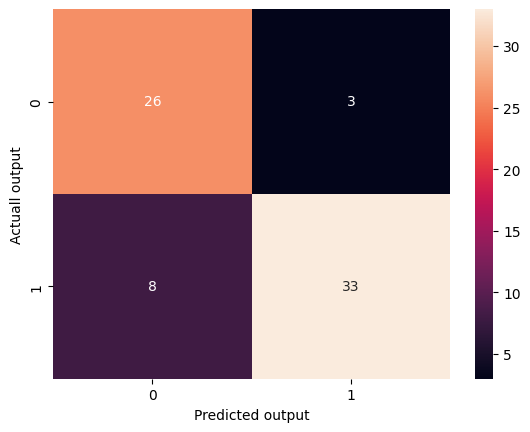

In [32]:
# futher exploring different prediction ratios using confusion matrix
def confusion_plot(pred):
    sns.heatmap(confusion_matrix(val_y,pred),annot=True)
    plt.ylabel("Actuall output")
    plt.xlabel("Predicted output")
confusion_plot(default_knn_pred)    

Model predicts lots of positive values as negatives which lowers true positive rate/recall, lowering decision threshold might help here, let's look at ROC curve 

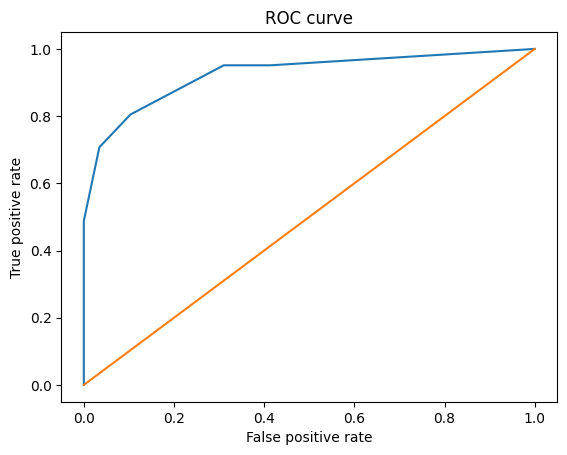

In [33]:
# ROC plot
def roc_plot(probs): 
    # roc_curve values
    fpr, tpr, thresh = roc_curve(val_y,probs)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1])
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.title("ROC curve")
    plt.show()

    
roc_plot(default_knn_pred_proba)    

In [34]:
# testing performance with different decision thresholds
for threshold in np.arange(0.1,1,0.1):
    print(f"Threshold: {threshold}")
    # if probability below or equal to threshold then prediction is 0, else 1
    pred = [0 if x <= threshold else 1 for x in default_knn_pred_proba]
    print(f"Accuracy: {accuracy_score(val_y,pred).round(2)*100}%")
    print(f"Precision: {precision_score(val_y,pred).round(2)}")
    print(f"Recall: {recall_score(val_y,pred).round(2)}")
    print()
    

Threshold: 0.1
Accuracy: 80.0%
Precision: 0.76
Recall: 0.95

Threshold: 0.2
Accuracy: 84.0%
Precision: 0.81
Recall: 0.95

Threshold: 0.30000000000000004
Accuracy: 84.0%
Precision: 0.81
Recall: 0.95

Threshold: 0.4
Accuracy: 84.0%
Precision: 0.92
Recall: 0.8

Threshold: 0.5
Accuracy: 84.0%
Precision: 0.92
Recall: 0.8

Threshold: 0.6
Accuracy: 81.0%
Precision: 0.97
Recall: 0.71

Threshold: 0.7000000000000001
Accuracy: 81.0%
Precision: 0.97
Recall: 0.71

Threshold: 0.8
Accuracy: 70.0%
Precision: 1.0
Recall: 0.49

Threshold: 0.9
Accuracy: 70.0%
Precision: 1.0
Recall: 0.49



With major recall improvement comes greater false positive rate, this is not desired situation. The default 50% threshold seems optimal

#### evaluation using cross-validation

1. Custom KFold

In [35]:
# custom KFold cross-validation
def kfold_auc(X,y,estimator):
    # "n" to keep track of which fold it is
    n = 1
    # lists to compute the mean of scores 
    accuracy_list = []
    auc_list = []
    precision_list = []
    recall_list = []
    # KFold() split
    for train,test in KFold(shuffle=True,n_splits=10,random_state=1).split(X,y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        
        # fit the estimator with training split
        estimator.fit(X_train,y_train)
        
        # predcint value and probability
        pred = estimator.predict(X_test)
        pred_proba = estimator.predict_proba(X_test)
        
        # computing scores
        accuracy = accuracy_score(y_test,pred).round(2)*100
        auc = roc_auc_score(y_test, pred_proba[:,list(estimator.classes_).index(1)]).round(2)
        precision = precision_score(y_test,pred).round(2)
        recall = recall_score(y_test,pred).round(2)  
        
        # appending scores to lists
        accuracy_list.append(accuracy)
        auc_list.append(auc)
        precision_list.append(precision)
        recall_list.append(recall)
         
        # printing all the information    
        print(f"Fold {n}")
        print(f"Accuracy: {accuracy}%")
        print(f"AUC: {auc}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print()
    
        n+=1
    
    print(f"""Mean accuracy: {np.array(accuracy_list).mean()}%
Mean AUC: {np.array(auc_list).mean()}
Mean precision: {np.array(precision_list).mean()}
Mean recall: {np.array(recall_list).mean()}
    """)
    
kfold_auc(X,y,pipe)        

Fold 1
Accuracy: 82.0%
AUC: 0.92
Precision: 0.88
Recall: 0.82

Fold 2
Accuracy: 82.0%
AUC: 0.89
Precision: 0.93
Recall: 0.76

Fold 3
Accuracy: 93.0%
AUC: 0.99
Precision: 0.88
Recall: 1.0

Fold 4
Accuracy: 75.0%
AUC: 0.86
Precision: 0.88
Recall: 0.74

Fold 5
Accuracy: 75.0%
AUC: 0.91
Precision: 0.62
Recall: 0.91

Fold 6
Accuracy: 89.0%
AUC: 0.95
Precision: 0.87
Recall: 0.93

Fold 7
Accuracy: 82.0%
AUC: 0.95
Precision: 0.76
Recall: 0.93

Fold 8
Accuracy: 82.0%
AUC: 0.8
Precision: 0.8
Recall: 0.94

Fold 9
Accuracy: 81.0%
AUC: 0.84
Precision: 0.87
Recall: 0.81

Fold 10
Accuracy: 89.0%
AUC: 0.99
Precision: 1.0
Recall: 0.81

Mean accuracy: 83.0%
Mean AUC: 0.9099999999999999
Mean precision: 0.849
Mean recall: 0.865
    


2. KFold

KFold without shuffling divides the data into N splits while maintaining its original order. However, when shuffle = True is set, the data samples are randomly shuffled before the split, ensuring that they are not divided based on their original order

In [36]:
# for this and all above cross-validation methods cross_validate wrapper will be used for convinience, and DataFrame for 
# readabilitiy
pd.DataFrame(cross_validate(pipe,X,y,cv=KFold(n_splits=10, shuffle=True,random_state=1),
               scoring=["accuracy","roc_auc","precision","recall"])).mean()

fit_time          0.012600
score_time        0.034000
test_accuracy     0.831085
test_roc_auc      0.908973
test_precision    0.847661
test_recall       0.865749
dtype: float64

3. Stratified KFold

Stratification ensures that target class distribution among folds is same as ratio from the whole dataset

In [37]:
pd.DataFrame(cross_validate(pipe,X,y,cv=StratifiedKFold(n_splits=10, shuffle=True,random_state=1),
               scoring=["accuracy","roc_auc","precision","recall"])).mean()

fit_time          0.012600
score_time        0.031899
test_accuracy     0.827381
test_roc_auc      0.893833
test_precision    0.845264
test_recall       0.860000
dtype: float64

4. Group KFold

The data is split based on given groups first and next based on given amount of splits. If there are more splits then groups, erro will occur

In [38]:
pd.DataFrame(cross_validate(pipe,X,y,cv=GroupKFold(n_splits=10),groups = np.random.randint(0, 10, size=X.shape[0]),
               scoring=["accuracy","roc_auc","precision","recall"])).mean()

fit_time          0.013205
score_time        0.037794
test_accuracy     0.840247
test_roc_auc      0.905310
test_precision    0.867393
test_recall       0.839725
dtype: float64

4. Stratified Group KFold

Folds are made based on groups and class distriubtion

In [39]:
pd.DataFrame(cross_validate(pipe,X,y,cv=StratifiedGroupKFold(n_splits=10),groups = np.random.randint(0, 10, size=X.shape[0]),
               scoring=["accuracy","roc_auc","precision","recall"])).mean()

fit_time          0.011600
score_time        0.034601
test_accuracy     0.818207
test_roc_auc      0.893106
test_precision    0.817741
test_recall       0.845518
dtype: float64

### Hyperparameter tuning

Instead of only tuning the hyperparameters of a model, the parameters of transformers can also be tune

In [40]:
# listing different hyperparameters for OneHotEncoder and KNeighborsClassifier
hyperparameters = {"transformer__onehotencoder__drop":["first","if_binary"],"kNN__n_neighbors":[5,10,15,20,25,50],
                "kNN__weights":["uniform","distance"],"kNN__algorithm":["auto","ball_tree","kd_tree"],
                "kNN__metric":["manhattan","minkowski"],"kNN__n_jobs":[-1]}

In [42]:
# GridSearchCV object instantiation
pipe_tuned = GridSearchCV(pipe,param_grid=hyperparameters,cv=10,n_jobs=-1,
                          scoring=["accuracy","roc_auc","precision","recall"],refit="accuracy")

In [43]:
# fitting the pipeline using GridSearhCV
pipe_tuned.fit(X,y);

In [44]:
# Best model found results
pd.DataFrame(pipe_tuned.cv_results_).iloc[pipe_tuned.best_index_].to_frame().loc[["mean_test_accuracy",
"mean_test_roc_auc","mean_test_precision","mean_test_recall"]]

,43
mean_test_accuracy,0.855952
mean_test_roc_auc,0.920271
mean_test_precision,0.859644
mean_test_recall,0.89625


### Default kNN vs tuned kNN comparison on the holdout (testing) dataset

In [45]:
# spliting holdout data into target and features
holdout_y = testing_data["output"]
holdout_X = testing_data.drop(columns="output")

In [46]:
# predictions with tuned kNN
tuned_pred = pipe_tuned.best_estimator_.predict(holdout_X)
tuned_pred_proba = pipe_tuned.best_estimator_.predict_proba(holdout_X)[:,1]

In [47]:
# refitting the default pipeline with all data
pipe.fit(X,y)
# predictions
default_pred = pipe.predict(holdout_X)
default_pred_proba = pipe.predict_proba(holdout_X)[:,1]

#### Tuned kNN results:

In [48]:
print(f"Accuracy: {accuracy_score(holdout_y,tuned_pred).round(2)*100}%")
print(f"AUC: {roc_auc_score(holdout_y,tuned_pred_proba).round(2)}")
print(f"Precision: {precision_score(holdout_y,tuned_pred).round(2)}")
print(f"Recall: {recall_score(holdout_y,tuned_pred).round(2)}")

Accuracy: 88.0%
AUC: 0.91
Precision: 0.77
Recall: 1.0


#### Default kNN results:

In [49]:
print(f"Accuracy: {accuracy_score(holdout_y,default_pred).round(2)*100}%")
print(f"AUC: {roc_auc_score(holdout_y,default_pred_proba).round(2)}")
print(f"Precision: {precision_score(holdout_y,default_pred).round(2)}")
print(f"Recall: {recall_score(holdout_y,default_pred).round(2)}")

Accuracy: 76.0%
AUC: 0.86
Precision: 0.67
Recall: 0.8


#### Summary:

<table>
  <tr>
    <th> </th>
    <th>Tuned kNN</th>
    <th>Default kNN</th>
  </tr>
  <tr>
    <td>Accuracy</td>
    <td>88.0%</td>
    <td>76.0%</td>
  </tr>
  <tr>
    <td>AUC</td>
    <td>0.91</td>
    <td>0.86</td>
  </tr>
  <tr>
    <td>Precision</td>
    <td>0.77</td>
    <td>0.67</td>
  </tr>
  <tr>
    <td>Recall</td>
    <td>1.0</td>
    <td>0.8</td>
  </tr>
</table>


### Thanks for reading!